# Image Classification - Cifar10 model (TFLite)
Developed by Marcelo Rovai - 19Aug20

Reference: [TensorFlow Lite inference](https://www.tensorflow.org/lite/guide/inference)
- Also see: [Python quickstart](https://www.tensorflow.org/lite/guide/python)

The term inference refers to the process of executing a TensorFlow Lite model on-device in order to make predictions based on input data. To perform an inference with a TensorFlow Lite model, you must run it through an interpreter. The TensorFlow Lite interpreter is designed to be lean and fast. The interpreter uses a static graph ordering and a custom (less-dynamic) memory allocator to ensure minimal load, initialization, and execution latency.

## Install just the TensorFlow Lite interpreter

To quickly run TensorFlow Lite models with Python, you can install just the TensorFlow Lite interpreter, instead of all TensorFlow packages.

For example, if you have Raspberry Pi that's running Raspbian Buster (which has Python 3.7), install the Python wheel as follows:

`$ sudo pip3 install https://dl.google.com/coral/python/tflite_runtime-2.1.0.post1-cp37-cp37m-linux_armv7l.whl`

## Libraries and setup

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tflite_runtime.interpreter as tflite

## Load Interpreter

In [111]:
!ls ./models

model_cifar10.tflite


In [77]:
interpreter = tflite.Interpreter(model_path='./models/model_cifar10.tflite')

In [78]:
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [79]:
input_details

[{'name': 'conv2d_12_input',
  'index': 0,
  'shape': array([ 1, 32, 32,  3]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0}}]

In [80]:
output_details

[{'name': 'Identity',
  'index': 17,
  'shape': array([ 1, 10]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0}}]

### Test the model on random input data.

In [81]:
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

In [83]:
input_data.shape

(1, 32, 32, 3)

In [82]:
input_data

array([[[[0.2485008 , 0.40165037, 0.23401776],
         [0.28254092, 0.4448997 , 0.5793751 ],
         [0.7153931 , 0.17747308, 0.38465196],
         ...,
         [0.33561796, 0.5863862 , 0.16401479],
         [0.820945  , 0.38323897, 0.9691964 ],
         [0.516108  , 0.13144143, 0.6415344 ]],

        [[0.98503673, 0.7250355 , 0.29269454],
         [0.03773272, 0.05092489, 0.73866653],
         [0.67219746, 0.7408584 , 0.5536305 ],
         ...,
         [0.503835  , 0.34604424, 0.02130186],
         [0.21136574, 0.99428034, 0.8898311 ],
         [0.05437457, 0.714125  , 0.85728145]],

        [[0.7083888 , 0.8305931 , 0.32105678],
         [0.2686036 , 0.6822804 , 0.24982351],
         [0.06242587, 0.7607834 , 0.6515359 ],
         ...,
         [0.22491947, 0.74090767, 0.70492226],
         [0.7554519 , 0.7107994 , 0.50444293],
         [0.15059167, 0.28511223, 0.55973244]],

        ...,

        [[0.41184348, 0.39145857, 0.25238195],
         [0.4341274 , 0.6295202 , 0.13398394]

In [84]:
interpreter.invoke()

In [85]:
# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[0.00245013 0.06610588 0.00190057 0.00322022 0.00130722 0.00155135
  0.8469468  0.00755497 0.00428525 0.0646777 ]]


## Test with a image

Functions based on [TensorFlow Lite Python image classification demo](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/lite/examples/python/)

In [90]:
def set_input_tensor(interpreter, image):
    tensor_index = interpreter.get_input_details()[0]['index']
    input_tensor = interpreter.tensor(tensor_index)()[0]
    input_tensor[:, :] = image

In [91]:
def classify_image(interpreter, image, top_k=1):
    """Returns a sorted array of classification results."""
    set_input_tensor(interpreter, image)
    interpreter.invoke()
    output_details = interpreter.get_output_details()[0]
    output = np.squeeze(interpreter.get_tensor(output_details['index']))

    # If the model is quantized (uint8 data), then dequantize the results
    if output_details['dtype'] == np.uint8:
        scale, zero_point = output_details['quantization']
        output = scale * (output - zero_point)

    ordered = np.argpartition(-output, top_k)
    return [(i, output[i]) for i in ordered[:top_k]]

In [86]:
!ls ./images/

car_1.jpg  car_3.jpg  car_5.jpg  cat_2.jpg  dog_1.jpg  dog_3.jpg   ship_2.jpg
car_2.jpg  car_4.jpg  cat_1.jpg  cat_2.png  dog_2.jpg  ship_1.jpg


In [94]:
image_path = "./images/cat_1.jpg"

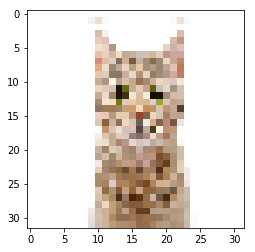

In [95]:
#Load input image
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (32, 32)) 
plt.imshow(img);

In [96]:
image = img.reshape(1,32,32,3)

In [97]:
results = classify_image(interpreter, image)

In [98]:
results

[(5, 1.0)]

In [101]:
results[0][0]

5

## Creating a function

In [99]:
classes_lst = ['Airplane', 'Automobile', 'Bird', 'Cat',
               'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

In [102]:
def predict_image(image_path, interpreter, classes_lst):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (32, 32)) 
    image = img.reshape(1,32,32,3)
    pred = classify_image(interpreter, image)[0][0]
    print("\n\t[PREDICTION]: ", classes_lst[pred])
    plt.imshow(img);


	[PREDICTION]:  Dog


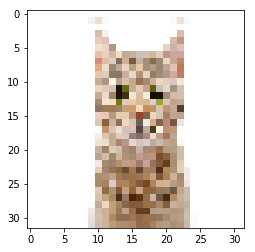

In [103]:
image_path = "./images/cat_1.jpg"
predict_image(image_path, interpreter, classes_lst)


	[PREDICTION]:  Cat


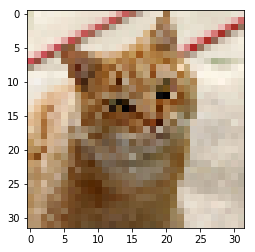

In [104]:
image_path = "./images/cat_2.jpg"
predict_image(image_path, interpreter, classes_lst)


	[PREDICTION]:  Dog


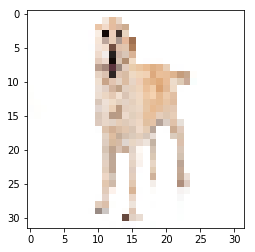

In [105]:
image_path = "./images/dog_1.jpg"
predict_image(image_path, interpreter, classes_lst)


	[PREDICTION]:  Automobile


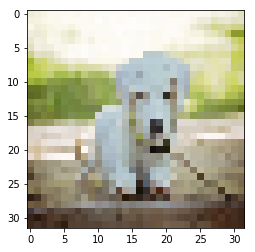

In [106]:
image_path = "./images/dog_2.jpg"
predict_image(image_path, interpreter, classes_lst)


	[PREDICTION]:  Dog


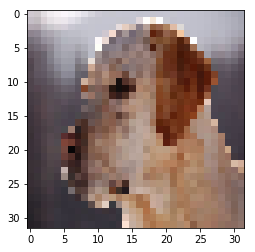

In [107]:
image_path = "./images/dog_3.jpg"
predict_image(image_path, interpreter, classes_lst)


	[PREDICTION]:  Automobile


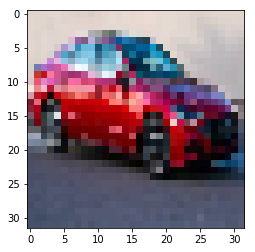

In [108]:
image_path = "./images/car_1.jpg"
predict_image(image_path, interpreter, classes_lst)


	[PREDICTION]:  Automobile


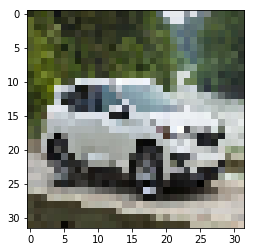

In [109]:
image_path = "./images/car_2.jpg"
predict_image(image_path, interpreter, classes_lst)


	[PREDICTION]:  Automobile


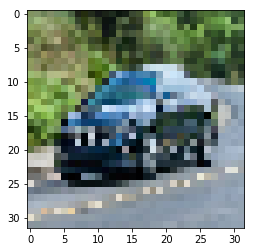

In [110]:
image_path = "./images/car_3.jpg"
predict_image(image_path, interpreter, classes_lst)